In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(r'/content/drive/MyDrive/Cody - AIMI 2024/2024 AIMI Summer Internship - Intern Materials/Datasets')

In [3]:
!unzip -qq student_data_split.zip -d /content/

In [4]:
# Switch back to /content/student_data_split folder to work with downloaded datasets
os.chdir(r'/content/student_data_split')

In [5]:
# Confirm we can now see the student_test and student_train folders + Reports.json
!ls

Reports.json  student_test  student_train


In [6]:
%%capture
%pip install "comet_ml>=3.38.0" torch torchvision tqdm
%pip install timm
%pip install scikit-multilearn

In [7]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import watch


In [8]:
import torch
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
from torchvision.transforms import v2
from torch import nn
from torchvision import models

import timm

from skmultilearn.model_selection import iterative_train_test_split
from torch.utils.data import DataLoader

In [9]:
dataframe = pd.read_pickle("/content/drive/MyDrive/Cody - AIMI 2024/train_data.pkl")

In [10]:
from torch.utils.data import Dataset

class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, transforms):
        self.dataframe = dataframe
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)


    def __getitem__(self, idx):
        out_dict = {"idx": torch.tensor(idx),}

        image_path = self.dataframe.loc[idx,'Image Path']
        labels = self.dataframe.loc[idx,'Encoded Labels']

        image = Image.open(image_path).convert("RGB")
        if(self.transforms is not None):
            image = self.transforms(image)

        out_dict["img"] = image
        out_dict["label"] = torch.tensor(labels, dtype=torch.float32)
        return out_dict["img"], out_dict["label"]


## Define Training Components
Here, define any necessary components that you need to train your model, such as the model architecture, the loss function, and the optimizer.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
#hyperparameters
batch_size = 64
learning_rate = 1e-4

num_epochs = 20
save_every_x_epochs = 2
current_epoch = 0

In [13]:
X_image_features = dataframe['Image Path'].to_numpy().reshape(-1, 1)
Y_labels = np.vstack(dataframe['Encoded Labels'])
X_image_train, y_labels_train, X_image_test, y_labels_test = iterative_train_test_split(X_image_features, Y_labels, test_size=0.20)

train_df = pd.DataFrame({'Image Path': X_image_train.flatten(), 'Encoded Labels':[l.tolist() for l in y_labels_train]})
val_df = pd.DataFrame({'Image Path': X_image_test.flatten(), 'Encoded Labels':[l.tolist() for l in y_labels_test]})

In [20]:
transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ChestXRayDataset(train_df, transforms)
val_dataset = ChestXRayDataset(val_df, transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


num_classes = 4
label_space = ['pneumonia', 'pneumothorax', 'pleural effusion', 'normal']

In [21]:
loss_fn = torch.nn.BCEWithLogitsLoss()

model = timm.create_model('tresnet_m', pretrained=True, num_classes=num_classes, drop_rate=0.2)
model.train()
model.to(device)
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/126M [00:00<?, ?B/s]

In [22]:
experiment = Experiment(
  api_key="REDACTED",
  project_name="aimi2024-tresnet_m",
  workspace="summit"
)
watch(model)


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/summit/aimi2024-tresnet-m/74c674d1832940f6b359805e27dde526

COMET INFO: Couldn't find a Git repository in '/content/student_data_split' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


## Training Code
We provide starter code below that implements a simple training loop in PyTorch. Feel free to modify as you see fit.

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, roc_auc_score

def calculate_metrics(pred, target, threshold=0.5):
    thresholded_preds = np.empty_like(pred)
    thresholded_preds[:] = pred
    thresholded_preds = np.array(thresholded_preds > threshold, dtype=float)

    f1 = f1_score(y_true=target, y_pred=thresholded_preds, average=None)
    f1_macro = f1_score(y_true=target, y_pred=thresholded_preds, average='macro')

    auc = roc_auc_score(y_true=target, y_score=pred, average=None)
    auc_macro = roc_auc_score(y_true=target, y_score=pred, average='macro')

    return {'f1': f1, 'f1_macro': f1_macro, 'auc': auc, 'auc_macro': auc_macro}

In [24]:
def train_one_epoch():
      train_loss = 0.0

      for index, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)

        opt.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        opt.step()

        train_loss += loss.item() * inputs.size(0)

      train_loss /= len(train_loader.dataset)
      return train_loss

In [25]:
threshold = 0.5
best_macro_f1 = 0.0 #higher f1 score is better, 1 is best

trainingEpoch_loss = []
validationEpoch_loss = []

In [26]:
# Epoch loop
for epoch in range(0, num_epochs):
  current_epoch += 1
  print(f"Training epoch {current_epoch}")

  model.train()
  train_loss = train_one_epoch()
  val_loss = 0.0

  print(f"Evaluating...")
  model.eval()

  with torch.no_grad():
    total_results = []
    total_targets = []

    for index, (data, target) in enumerate(tqdm(val_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)

        total_results.extend(output.cpu().numpy())
        total_targets.extend(target.cpu().numpy())

        val_loss += loss_fn(output, target).item() * target.size(0)

  val_loss /= len(val_loader.dataset)

  trainingEpoch_loss.append(train_loss)
  validationEpoch_loss.append(val_loss)

  metrics = calculate_metrics(np.array(total_results), np.array(total_targets), threshold=threshold)
  print(f'LOSS: train {train_loss} valid {val_loss}')
  print(f'Macro F1 Score: {metrics["f1_macro"]}   Class Breakdown: {metrics["f1"]}')
  print(f'Macro AUROC: {metrics["auc_macro"]}   Class Breakdown: {metrics["auc"]}')

  #Log to Comet
  experiment.log_metric("train loss", train_loss, epoch=current_epoch)
  experiment.log_metric("val loss", val_loss, epoch=current_epoch)
  experiment.log_metric("macro f1", metrics["f1_macro"], epoch=current_epoch)
  experiment.log_metric("macro auroc", metrics["auc_macro"], epoch=current_epoch)

  #Save best checkpoint based on F1 Score
  #F1 Score preferred over AUROC b/c of data imbalance - https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc
  if(metrics["f1_macro"] > best_macro_f1):
      best_macro_f1 = metrics["f1_macro"]
      state = {
          'epoch': current_epoch,
          'state_dict': model.state_dict(),
          'optimizer': opt.state_dict(),
      }
      save_path = f'/content/drive/MyDrive/Cody - AIMI 2024/Trains/best.ckpt'
      torch.save(state, save_path)

  #Save every x epochs
  if(current_epoch % save_every_x_epochs == 0):
      save_path = f'/content/drive/MyDrive/Cody - AIMI 2024/Trains/model-epoch-{current_epoch}.pth'
      torch.save(model.state_dict(), save_path)  # Save model weights for inference


Training epoch 1


100%|██████████| 210/210 [04:34<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:40<00:00,  1.30it/s]


LOSS: train 0.5255172708105214 valid 0.5153373935863154
Macro F1 Score: 0.1639257307824379   Class Breakdown: [0.         0.53287414 0.12282878 0.        ]
Macro AUROC: 0.6242289318767752   Class Breakdown: [0.67996251 0.62712    0.60035018 0.58948304]
Training epoch 2


100%|██████████| 210/210 [04:07<00:00,  1.18s/it]


Evaluating...


100%|██████████| 53/53 [00:40<00:00,  1.30it/s]


LOSS: train 0.50283741707632 valid 0.5105048866058464
Macro F1 Score: 0.2443531549688759   Class Breakdown: [0.         0.64090786 0.33650476 0.        ]
Macro AUROC: 0.6382638914557552   Class Breakdown: [0.69627133 0.64591483 0.60719516 0.60367425]
Training epoch 3


100%|██████████| 210/210 [04:11<00:00,  1.20s/it]


Evaluating...


100%|██████████| 53/53 [00:40<00:00,  1.30it/s]


LOSS: train 0.4936666715839655 valid 0.5056187878615821
Macro F1 Score: 0.22727346874373455   Class Breakdown: [0.         0.6385311  0.27056277 0.        ]
Macro AUROC: 0.6508851570984218   Class Breakdown: [0.70991494 0.65899198 0.61872062 0.6159131 ]
Training epoch 4


100%|██████████| 210/210 [04:06<00:00,  1.17s/it]


Evaluating...


100%|██████████| 53/53 [00:39<00:00,  1.35it/s]


LOSS: train 0.4798319319235623 valid 0.5138733421154876
Macro F1 Score: 0.18622345083910657   Class Breakdown: [0.         0.58561237 0.15928144 0.        ]
Macro AUROC: 0.6422625500031035   Class Breakdown: [0.70465675 0.65084837 0.61371263 0.59983244]
Training epoch 5


100%|██████████| 210/210 [04:14<00:00,  1.21s/it]


Evaluating...


100%|██████████| 53/53 [00:38<00:00,  1.38it/s]


LOSS: train 0.4653646850653438 valid 0.5250978224846854
Macro F1 Score: 0.22351559141202015   Class Breakdown: [0.04379562 0.67507568 0.17519106 0.        ]
Macro AUROC: 0.6412974361034613   Class Breakdown: [0.71682288 0.64928715 0.61076712 0.58831259]
Training epoch 6


100%|██████████| 210/210 [04:07<00:00,  1.18s/it]


Evaluating...


100%|██████████| 53/53 [00:41<00:00,  1.29it/s]


LOSS: train 0.44600198778163264 valid 0.5206151663367428
Macro F1 Score: 0.2422260336826203   Class Breakdown: [0.02506266 0.60841424 0.32290114 0.0125261 ]
Macro AUROC: 0.651532196429949   Class Breakdown: [0.70737938 0.67390324 0.61440676 0.6104394 ]
Training epoch 7


100%|██████████| 210/210 [04:05<00:00,  1.17s/it]


Evaluating...


100%|██████████| 53/53 [00:40<00:00,  1.32it/s]


LOSS: train 0.42154126072885595 valid 0.5474726802911332
Macro F1 Score: 0.29555873138477645   Class Breakdown: [0.18992248 0.5933549  0.34807692 0.05088063]
Macro AUROC: 0.6417264490354211   Class Breakdown: [0.70306529 0.65429272 0.61154485 0.59800294]
Training epoch 8


100%|██████████| 210/210 [04:09<00:00,  1.19s/it]


Evaluating...


100%|██████████| 53/53 [00:38<00:00,  1.36it/s]


LOSS: train 0.3900635602079513 valid 0.560157602847512
Macro F1 Score: 0.33464950370164065   Class Breakdown: [0.1511879  0.64827217 0.47500969 0.06412826]
Macro AUROC: 0.642318367412861   Class Breakdown: [0.69462243 0.6639025  0.60983704 0.60091149]
Training epoch 9


100%|██████████| 210/210 [04:09<00:00,  1.19s/it]


Evaluating...


100%|██████████| 53/53 [00:39<00:00,  1.33it/s]


LOSS: train 0.3512260382016642 valid 0.6031656561858618
Macro F1 Score: 0.3132437697632396   Class Breakdown: [0.11685393 0.66684087 0.38809947 0.08118081]
Macro AUROC: 0.6332265769459893   Class Breakdown: [0.68681825 0.66420992 0.5967594  0.58511874]
Training epoch 10


100%|██████████| 210/210 [04:11<00:00,  1.20s/it]


Evaluating...


100%|██████████| 53/53 [00:40<00:00,  1.31it/s]


LOSS: train 0.31344958861828776 valid 0.6625670903298392
Macro F1 Score: 0.34223997735806955   Class Breakdown: [0.19895288 0.66057441 0.3772587  0.13217391]
Macro AUROC: 0.6264954032164232   Class Breakdown: [0.67388293 0.64755031 0.59009934 0.59444904]
Training epoch 11


100%|██████████| 210/210 [04:08<00:00,  1.18s/it]


Evaluating...


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


LOSS: train 0.270700515306861 valid 0.6861895645376461
Macro F1 Score: 0.3320790969857799   Class Breakdown: [0.19202899 0.68434217 0.3286119  0.12333333]
Macro AUROC: 0.6257537692045967   Class Breakdown: [0.67062691 0.64919321 0.58195042 0.60124453]
Training epoch 12


100%|██████████| 210/210 [04:06<00:00,  1.17s/it]


Evaluating...


100%|██████████| 53/53 [00:40<00:00,  1.32it/s]


LOSS: train 0.23174735625744788 valid 0.7658993316942186
Macro F1 Score: 0.37152839393477566   Class Breakdown: [0.22335025 0.68756269 0.45888399 0.11631664]
Macro AUROC: 0.6215612813276585   Class Breakdown: [0.66794605 0.65429494 0.57596205 0.58804209]
Training epoch 13


100%|██████████| 210/210 [04:09<00:00,  1.19s/it]


Evaluating...


100%|██████████| 53/53 [00:38<00:00,  1.36it/s]


LOSS: train 0.199881389790419 valid 0.7869114660505039
Macro F1 Score: 0.355497540361134   Class Breakdown: [0.19813084 0.69273473 0.45759518 0.07352941]
Macro AUROC: 0.6223058867951025   Class Breakdown: [0.68013915 0.6522815  0.58174197 0.57506093]
Training epoch 14


100%|██████████| 210/210 [04:06<00:00,  1.18s/it]


Evaluating...


100%|██████████| 53/53 [00:39<00:00,  1.33it/s]


LOSS: train 0.16622173839897214 valid 0.8622877920207692
Macro F1 Score: 0.3679624960308989   Class Breakdown: [0.23639191 0.67942346 0.43311102 0.12292359]
Macro AUROC: 0.6246324569914604   Class Breakdown: [0.66437591 0.65361476 0.57589836 0.6046408 ]
Training epoch 15


100%|██████████| 210/210 [04:12<00:00,  1.20s/it]


Evaluating...


100%|██████████| 53/53 [00:40<00:00,  1.30it/s]


LOSS: train 0.14024150861817702 valid 0.8964016628087457
Macro F1 Score: 0.374658365835827   Class Breakdown: [0.22910217 0.6839587  0.44928099 0.1362916 ]
Macro AUROC: 0.6222873855141398   Class Breakdown: [0.66596737 0.66126643 0.57087481 0.59104093]
Training epoch 16


100%|██████████| 210/210 [04:08<00:00,  1.18s/it]


Evaluating...


100%|██████████| 53/53 [00:38<00:00,  1.38it/s]


LOSS: train 0.11894229850356403 valid 0.9594237366007335
Macro F1 Score: 0.38266479433178413   Class Breakdown: [0.22690438 0.65989054 0.48904594 0.15481833]
Macro AUROC: 0.6231905920600501   Class Breakdown: [0.67271609 0.65410782 0.58268327 0.58325519]
Training epoch 17


100%|██████████| 210/210 [04:08<00:00,  1.18s/it]


Evaluating...


100%|██████████| 53/53 [00:37<00:00,  1.40it/s]


LOSS: train 0.09988216078540302 valid 1.0047000631289695
Macro F1 Score: 0.37328964921867436   Class Breakdown: [0.21100917 0.65889213 0.4723139  0.1509434 ]
Macro AUROC: 0.6200619139467751   Class Breakdown: [0.66174899 0.66102993 0.57497732 0.58249142]
Training epoch 18


100%|██████████| 210/210 [04:06<00:00,  1.17s/it]


Evaluating...


100%|██████████| 53/53 [00:39<00:00,  1.34it/s]


LOSS: train 0.08837170075475859 valid 1.0307305459833858
Macro F1 Score: 0.3789532683506439   Class Breakdown: [0.23426061 0.68004957 0.47531993 0.12618297]
Macro AUROC: 0.6145312550673239   Class Breakdown: [0.65823193 0.65101285 0.57776251 0.57111773]
Training epoch 19


100%|██████████| 210/210 [04:07<00:00,  1.18s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.44it/s]


LOSS: train 0.0785640783212727 valid 1.0921638674878362
Macro F1 Score: 0.38290761452078975   Class Breakdown: [0.27350427 0.66886076 0.44410413 0.14516129]
Macro AUROC: 0.6219375177902193   Class Breakdown: [0.67089143 0.65072325 0.57707272 0.58906267]
Training epoch 20


100%|██████████| 210/210 [04:12<00:00,  1.20s/it]


Evaluating...


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


LOSS: train 0.06951924939401867 valid 1.1518588203814493
Macro F1 Score: 0.3798606894412539   Class Breakdown: [0.24435591 0.68743818 0.47954056 0.10810811]
Macro AUROC: 0.6235711179676033   Class Breakdown: [0.66813747 0.65190614 0.58101889 0.59322197]


In [28]:
#Save last ckpt
state = {
    'epoch': current_epoch,
    'state_dict': model.state_dict(),
    'optimizer': opt.state_dict(),
}
save_path = f'/content/drive/MyDrive/Cody - AIMI 2024/Trains/last.ckpt'
torch.save(state, save_path)

In [30]:
experiment.end()

# Loss curves

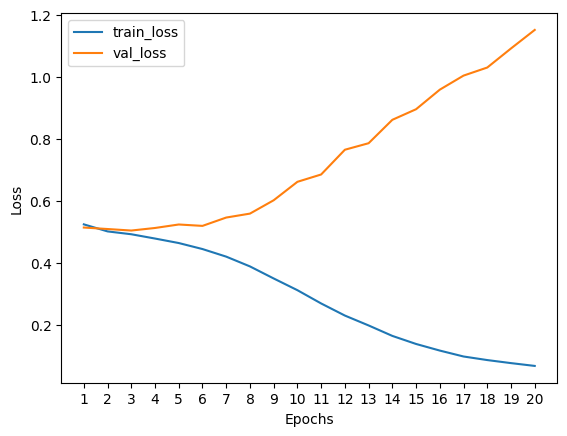

In [31]:
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(len(trainingEpoch_loss)), np.arange(1, len(trainingEpoch_loss)+1))
plt.legend()

plt.savefig('/content/drive/MyDrive/Cody - AIMI 2024/Trains/train_val_loss.png')
plt.show()

# Evaluating on Test Dataset


In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('tresnet_m', pretrained=False, num_classes=num_classes)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

checkpoint = torch.load(r'/content/drive/MyDrive/Cody - AIMI 2024/Trains/model-epoch-6.pth')
#model.load_state_dict(checkpoint['state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer'])
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [32]:
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def getImage(image_path):
  image = Image.open(image_path).convert("RGB")
  image = test_transforms(image)
  return image

In [33]:
threshold = 0.5

def predict(model, image_tensor):
  model.eval()
  with torch.no_grad():
      input = image_tensor.unsqueeze(0)  #image lacks batch layer, so insert a batch dimension of size 1
      input = input.to(device)

      outputs = model(input).cpu()
      preds = np.array(outputs)

      rounded_preds, thresholded_preds = np.empty_like(preds), np.empty_like(preds)
      rounded_preds[:] = preds
      thresholded_preds[:] = preds

      for(i, pred) in enumerate(preds):
              thresholded_preds[i] = (pred > threshold).astype(int)
              if(np.all(thresholded_preds[i] == 0)):
                thresholded_preds[i] = [0, 0, 0, 1]
              rounded_preds[i] = [round(num, 7) for num in pred]

      return thresholded_preds[0], rounded_preds[0]


In [34]:
test_dataframe = pd.read_csv("/content/drive/MyDrive/Cody - AIMI 2024/2024 AIMI Summer Internship - Intern Materials/Datasets/test_annotations.csv")
os.chdir(r'/content/student_data_split')

In [47]:
#np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

processed_patients = []
#number_pneumonia = 0 #temporary just to double check

for index, row in tqdm(test_dataframe.iterrows(), total=test_dataframe.shape[0]):
  images = os.listdir(row['study_id'])
  for image in images:
    thresholded_preds, rounded_preds = predict(model, getImage(row['study_id'] + '/' + image))

    patient = {
        'study_id' : row['study_id'],
        'Pneumothorax' : thresholded_preds[1],
        'Pneumonia' : thresholded_preds[0],
        'Pleural Effusion' : thresholded_preds[2],
        'No Finding' : thresholded_preds[3],
        'Pneumothorax Probs' : rounded_preds[1],
        'Pneumonia Probs' : rounded_preds[0],
        'Pleural Effusion Probs' : rounded_preds[2],
        'No Finding Probs' : rounded_preds[3],
    }

    #temporary, check # of pneumonia to make sure not exporting wrong
    #if(thresholded_preds[0] == 1):
    #  number_pneumonia += 1

    processed_patients.append(patient)

    break # too lazy to deal/combine output from multiple images for now, will handle later

#print(f"\n {number_pneumonia} pneumonia detected")

100%|██████████| 2983/2983 [01:36<00:00, 30.89it/s]


In [49]:
test_processed_dataframe = pd.DataFrame(processed_patients)
test_processed_dataframe.to_csv(r'/content/drive/MyDrive/Cody - AIMI 2024/test_results.csv', index=False, float_format='%.10f')

# Submitting Your Results
Once you have successfully trained your model, generate predictions on the test set and save your results as a `.csv` file. This file can then be uploaded to the leaderboard: https://vilmedic.app/misc/aimi24/leaderboard.

An example `test_results.csv` has been provided for reference only in the `2024 AIMI Summer Internship - Intern Materials/Datasets/Labels` folder. *Do not submit this, the results will be really poor. *

Your final `.csv` file **must** have the following format:
- There must be a column titled `study_id` with the paths to the study_id for the test set image, e.g. `student_test/patient35172/study3`.
- The provided columns from `test_annotations.csv` must be present: "Pneumothorax", "Pneumonia", "Pleural Effusion", "No Finding:
  - Each of these columns must contain a binary value `0` or `1` representing the **observed/ground-truth** absence or presence of the disease status.
- Added columns "Pneumothorax Probs", "Pneumonia Probs", "Pleural Effusion Probs", "No Finding Probs" containing the singular probability values belonging to each class.
  - Each of these columns must contain a continuous value representing the **predicted** probability of the absence or presence of the disease status for that class.
  - *Hint:* Depending on which loss function you used, you might already be outputing probabilities. You can then derive predictions by thresholding your probabilities to a binarized output. If your model outputs logits directly, then apply the sigmoid activation function `torch.sigmoid(logits)` to get probabilities and then threshold to get binary predictions.
- Double check that the length of the dataset passed into your dataloader matches the length of your final dataframe.

In [ ]:
model = # Model Architecture
ckpt = torch.load("/content/best.pkl")
model.load_state_dict(ckpt["state_dict"])

test_dataset = ChestXRayDataset("""Fill in args here""")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, drop_last=False)

In [ ]:
# Write method to load in data from test_loader, compute model predictions, and append results to test_results dict
test_results = {"image_path": [], "pred": []}

In [ ]:
test_results = pd.DataFrame(test_results)
test_results.to_csv(f"/content/test_results.csv")